# Qarameterized circuits

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm

In [2]:
plt.rcParams.update({'font.size': 16})

## Parameterized random circuits with some classical and some quantum parameters

Modified versions of circuits from [pennylane.ai/qml/demos/tutorial_barren_plateaus.html](https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html)

In [3]:
gate_set = [qml.RX, qml.RY, qml.RZ]
ctrl_gate_set = [qml.CRX, qml.CRY, qml.CRZ]

In [4]:
class RandomCircuit:
    gate_set = [qml.RX, qml.RY, qml.RZ]
    ctrl_gate_set = [qml.CRX, qml.CRY, qml.CRZ]
    
    def __init__(self, num_qubits, precision_qparams=5, max_qparams=2*np.pi,
                 include_max=False, random_gateidx_sequence=None, seed=None):
        self.num_qubits = self.num_params = num_qubits
        self.precision_qparams = precision_qparams
        self.max_qparams = max_qparams
        
        self.num_bins = 2**precision_qparams
        if include_max:
            self.num_bins -= 1
        
        if random_gateidx_sequence is None:
            if seed is not None:
                np.random.seed(seed)
            self.random_gateidx_sequence = np.random.choice(3, self.num_params)
        else:
            self.random_gateidx_sequence = random_gateidx_sequence
        
        self.devices = [qml.device('default.qubit', wires=num_qubits+i*precision_qparams) for i in range(self.num_params+1)]
        
        self.__init_target_prob__()
    
    @qml.template
    def rand_circuit(self, cparams, num_qparams):
        num_cparams = self.num_params - num_qparams # Numbers of classical and "quantum" parameters
        
        # Wires:
        #   First `num_qubits` wires form the main register.
        #   After that, every `precision_qparams` wires coresponds to one qparam.
        
        num_wires = self.num_qubits + num_qparams*self.precision_qparams
        
        for i in range(self.num_qubits):
            qml.RY(np.pi/4, wires=i)
        
        for i in range(num_cparams):
            self.gate_set[self.random_gateidx_sequence[i]](cparams[i], wires=i)
        
        for i in range(num_cparams, self.num_params):
            ctrl_gate = self.ctrl_gate_set[self.random_gateidx_sequence[i]]
            for j in range(self.precision_qparams):
                ctrl_wire = self.num_qubits + (i-num_cparams)*self.precision_qparams + j
                
                #j = 0 is the least significant
                ctrl_angle = self.max_qparams*2**(self.precision_qparams-j-1) / self.num_bins
                
                ctrl_gate(ctrl_angle, wires=[ctrl_wire, i])
        
        for i in range(self.num_qubits-1):
            qml.CZ(wires=[i, i+1])
    
    def __init_target_prob__(self):
        @qml.qnode(self.devices[0])
        def func(cparams):
            self.rand_circuit(cparams, num_qparams=0)
            
            H = np.zeros((2**self.num_qubits, 2**self.num_qubits))
            H[0, 0] = 1
            return qml.expval(qml.Hermitian(H, wires=range(self.num_qubits)))
        self.target_prob = func
    
    # Quantum oracle to evaluate the state of the control registers
    @qml.template
    def oracle(self, cparams, num_qparams):
        diag = np.ones(2**self.num_qubits)
        diag[0] *= -1
                
        qml.inv(self.rand_circuit(cparams, num_qparams))
        qml.DiagonalQubitUnitary(diag, wires=range(self.num_qubits))
        
        self.rand_circuit(cparams, num_qparams)
        qml.DiagonalQubitUnitary(diag, wires=range(self.num_qubits))
    
    # Non-Boolean Amplitude Amplification circuit
    def make_amplitude_amplification_circuit(self, num_qparams, K):
        assert num_qparams <= self.num_params
        num_wires = self.num_qubits + num_qparams*self.precision_qparams
        
        @qml.template
        def init_circuit(cparams):
            # Initialize control registers to a uniform superposition state
            for i in range(self.num_qubits, num_wires):
                qml.Hadamard(wires=i)
            
            # Couple the control registers to main register (initialize main register basedon the state of the control)
            self.rand_circuit(cparams, num_qparams)
        
        @qml.qnode(self.devices[num_qparams])
        def circuit_aux(cparams):
            diag = np.ones(2**num_wires)
            diag[0] *= -1
            
            # Initialization
            init_circuit(cparams)
            
            # Non-Boolean Amplitude Amplification go brrrrr
            for k in range(1, K+1):
                # Act the oracle during odd iterations, or its inverse during the even iterations
                if k%2 == 1:
                    self.oracle(cparams, num_qparams)
                else:
                    qml.inv(self.oracle(cparams, num_qparams))
                
                # Diffusion operator
                qml.inv(init_circuit(cparams))
                qml.DiagonalQubitUnitary(diag, wires=range(num_wires))
                init_circuit(cparams)
            
            # Measurement of the control registers post amplification
            return qml.probs(wires=range(self.num_qubits, num_wires))
        
        def amplified_probs(cparams):
            probs = circuit_aux(cparams)
            probs_dict = {}
            for i in range(len(probs)):
                tmp, key = i, []
                for j in range(num_qparams):
                    key.append(tmp % 2**self.precision_qparams)
                    tmp //= 2**self.precision_qparams
                
                key = tuple(key)
                probs_dict[key] = float(probs[i])
            return probs_dict
        
        return circuit_aux, amplified_probs

## All parameters classical

In [5]:
NUM_QUBITS = 2
PRECISION = 5
SEED = 10

rc = RandomCircuit(num_qubits=NUM_QUBITS, precision_qparams=PRECISION, seed=SEED)

In [13]:
print(rc.rand_circuit(2, 0).draw())

TypeError: 'int' object is not subscriptable

In [16]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

cparam_0_binedges = np.linspace(0-binwidth/2, 2*np.pi+binwidth/2, num=2**PRECISION+1, endpoint=True)
cparam_1_binedges = np.linspace(0-binwidth/2, 2*np.pi+binwidth/2, num=2**PRECISION+1, endpoint=True)
cparam_0_binedges, cparam_1_binedges = np.meshgrid(cparam_0_binedges, cparam_1_binedges)

cparam_0_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
cparam_1_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
cparam_0_vals, cparam_1_vals = np.meshgrid(cparam_0_vals, cparam_1_vals)

score_landscape = np.zeros_like(cparam_0_vals)
for idx in np.ndindex(cparam_0_vals.shape):
    score_landscape[idx] = rc.target_prob([cparam_0_vals[idx], cparam_1_vals[idx]])

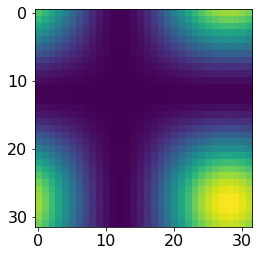

In [24]:
plt.imshow(score_landscape)

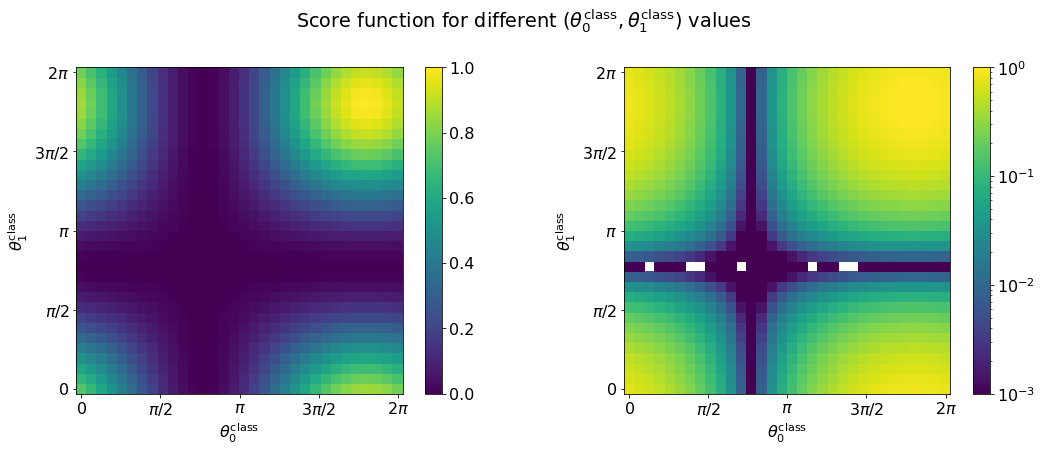

In [22]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(cparam_0_binedges, cparam_1_binedges, score_landscape)
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')

_ = ax1.pcolormesh(cparam_0_binedges, cparam_1_binedges, score_landscape, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta^\mathrm{class}_0$')
    ax.set_ylabel(r'$\theta^\mathrm{class}_1$')

fig.suptitle(r"Score function for different $(\theta^\mathrm{class}_0, \theta^\mathrm{class}_1)$ values", y=1.02)
None

## All parameters quantum

The circuit is parameterized by control quantum registers.

* The control registers are initialized to a uniform superposition.
* The different basis states of the control registers are preferetially amplified.
* The control registers are measured post-amplification, and the measurement probabilities are plotted.

### One iteration of the amplification algorithm (K=1)

In [26]:
ampl_circuit, ampl_prob_func = rc.make_amplitude_amplification_circuit(num_qparams=2, K=1)
amplified_probs = ampl_prob_func(cparams=[])

In [27]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

qparam_0_binedges = np.linspace(0-binwidth/2, 2*np.pi-binwidth/2, num=2**PRECISION+1, endpoint=True)
qparam_1_binedges = np.linspace(0-binwidth/2, 2*np.pi-binwidth/2, num=2**PRECISION+1, endpoint=True)
qparam_0_binedges, qparam_1_binedges = np.meshgrid(qparam_0_binedges, qparam_1_binedges)

qparam_0_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
qparam_1_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
qparam_0_vals, qparam_1_vals = np.meshgrid(qparam_0_vals, qparam_1_vals)

probabilities = np.zeros_like(qparam_0_vals)
for idx in np.ndindex(qparam_0_vals.shape):
    probabilities[idx] = amplified_probs[idx]

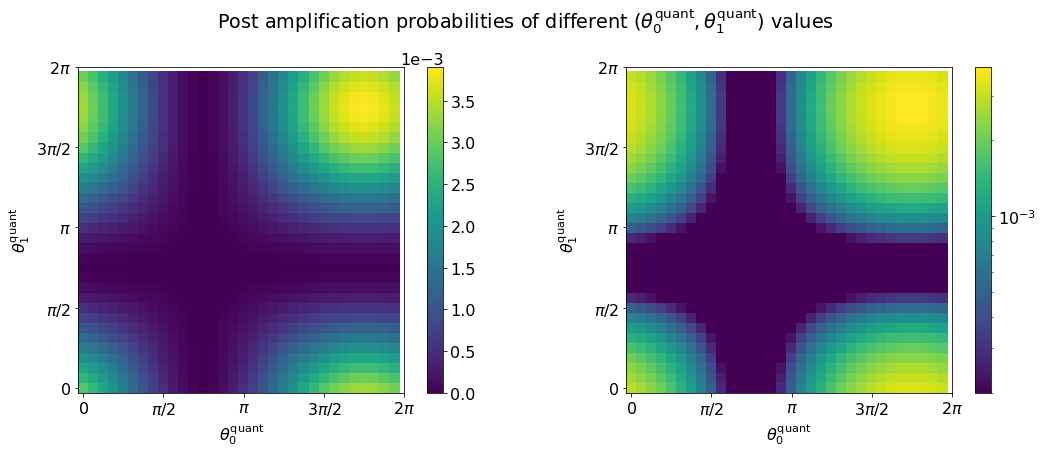

In [28]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(qparam_0_binedges, qparam_1_binedges, probabilities)
cbar = plt.colorbar(_, ax=ax0)
cbar.formatter.set_powerlimits((0, 0))
ax0.set_aspect('equal')

_ = ax1.pcolormesh(qparam_0_binedges, qparam_1_binedges, probabilities, norm=LogNorm(vmin=2e-4))
cbar = plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta^\mathrm{quant}_0$')
    ax.set_ylabel(r'$\theta^\mathrm{quant}_1$')

fig.suptitle(r"Post amplification probabilities of different $(\theta^\mathrm{quant}_0, \theta^\mathrm{quant}_1)$ values", y=1.02)
None